# Creating and managing the initial samples

You need the initial samples of the voice, clean and with a proper volume. 

This notebook addresses the specific case, when you have an audio or video that contains multiple voice samples without the backgrounds noises. In my case, some good person have prepared such videos by taking the voice samples from a videogame, concatenating them to the video and posting to Youtube. It can also be a video a-la "[Character] moments", where equally good people concatenate the scenes with the character of your choice.

In this case, 
* Download this video with whatever still works after YouTube's last update
* Edit the video in Kdelive or another video editor of your choice, and
    * Cut the video to the individual sentences
    * Remove sentences you don't like (too emotional, too short, with background noise)
    * Place >1 sec pause between the remaining fragments.
* Place this file in `/temp/source.wav`

To avoid overburdening the repo with unnecessary media files, I will create this `source.wav` by Piper. 

First, I will install Piper if it's not installed.

In [1]:
from brainbox import BrainBox
from brainbox.deciders import Piper

api = BrainBox.Api('127.0.0.1:8090')
api.controller_api.install_if_not_installed(Piper)

Now let's create the file:

In [2]:
from brainbox.deciders import Collector
from ipywidgets import Audio
from chara.tools import Language, WavProcessor
from yo_fluq import FileIO
from pathlib import Path
import numpy as np
import os


source = Path('temp/source.wav')
os.makedirs('temp', exist_ok = True)

if not source.is_file():
    sentences = Language.English().sample_text
    builder = Collector.TaskBuilder()
    for s in sentences:
        builder.append(
            BrainBox.Task.call(Piper).voiceover(s),
            dict()
        )
    opentts = api.execute(builder.to_collector_pack('to_array'))
    
    
    frames = []
    
    for i, voiceover in enumerate(opentts):
        proc = WavProcessor(api.download(voiceover['result']))
        silence = proc.create_silence(2)
        if i == 0:
            frames.append(silence)
        frames.append(proc.frames)
        frames.append(silence)
    
    FileIO.write_bytes(proc.frames_to_wav_bytes(np.vstack(frames)), source)


The following code will analyze the file, detect the samples by a silence margin, cuts it, stores in the folder, and also draws some supplementary plots.

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

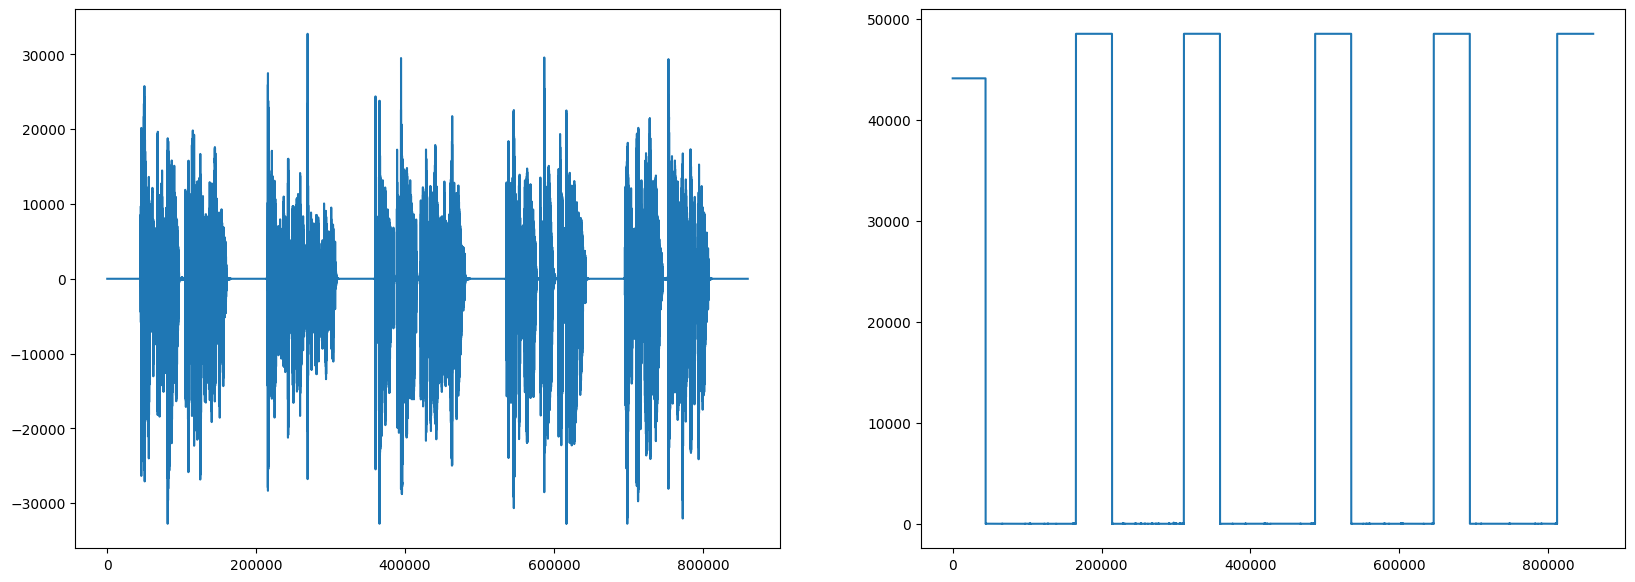

In [3]:
from chara.voice_clone.samples import AudioCutter
import shutil

output = Path('temp/samples')
shutil.rmtree(output, ignore_errors=True)
cutter = AudioCutter(source, output/'character')
cutter.make_all()

In [4]:
from yo_fluq import Query

files = Query.folder(output,'**/*').select(lambda z: z.relative_to(output)).to_list()
assert len(files) == 6, "The number of cut files is wrong"
files[:4]

[PosixPath('character'),
 PosixPath('character/4.wav'),
 PosixPath('character/3.wav'),
 PosixPath('character/2.wav')]

The following code builds statistics for the created samples in the `output` folder, which should be organized as `output/character_1/...`, `output/character_2/...` etc (this file structure is also used by the other services down the stream). The function returns the list of dictionaries with the relevant fields, but I think it's easier to view as Pandas dataframe.

In [5]:
from chara.voice_clone.samples import build_statistics
import pandas as pd

df = pd.DataFrame(build_statistics(output))
df.head()

,path,character,file,length,volume
0,temp/samples/character/4.wav,character,4.wav,5.294150,74.593013
1,temp/samples/character/3.wav,character,3.wav,5.015510,74.091589
2,temp/samples/character/2.wav,character,2.wav,5.758549,74.019264
3,temp/samples/character/1.wav,character,1.wav,4.365351,71.485257
4,temp/samples/character/0.wav,character,0.wav,5.479909,74.134356


We can compute some statistics:

In [6]:
df.groupby('character').length.sum()

character
character    25.913469
Name: length, dtype: float64

In [7]:
df.groupby('character').volume.mean()

character
character    73.664696
Name: volume, dtype: float64

Around 70 is, by my observation, good volume. If the volume is too high or too low, it may affect upsampling. To prevent it, use `change_volume` function.

In [8]:
from chara.voice_clone.samples import change_volume
change_volume(output/'character/0.wav', output/'character_2/00.wav', 0.1)
df1 = pd.DataFrame(build_statistics(output))
s = df1.groupby('character').volume.mean()
assert s['character_2'] < s['character']
s

character
character      73.664696
character_2    54.134356
Name: volume, dtype: float64